In [1]:
import re
import string
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import spacy
from spacy import displacy
from spacy.pipeline import merge_entities

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA, NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.metrics import pairwise_distances

from corextopic import corextopic as ct
from corextopic import vis_topic as vt


In [2]:
df = pd.read_csv('movie_summaries.csv', index_col=0)
df['original_summary'] = df['summary']

In [3]:
# remove digits from docs
df['summary'] = df['summary'].str.replace('\d+', ' ', regex=True)


# Baseline Topic Models

In [4]:
def make_topics(docs, vectorizer, topic_modeler, n_words=15):
    
    # Vectorize documents into a document-word matrix.
    doc_word_vectors = vectorizer.fit_transform(docs)
    
    # Fit the topic model.
    doc_topic_vectors = topic_modeler.fit_transform(doc_word_vectors)
    
    # Print the topics.
    vocab = vectorizer.get_feature_names()
    for idx, topic in enumerate(topic_modeler.components_):
        # Select the top 15 words in vocab for this topic.
        top_words = [vocab[i].upper() for i in topic.argsort()[:-n_words-1:-1]]
        print(f'Topic {idx}:\n', ', '.join(top_words), '\n')
    
    return doc_word_vectors, doc_topic_vectors


In [5]:
def token_formatter(token, doc_entities):
    
    token_text = token.lemma_.lower().strip().replace('star ', '')
    
    if 'academy award' in token.text.lower():
        return 'academy award'
        
    elif token.text in doc_entities:
        token_string = re.sub(f'[{string.punctuation}]+', ' ', token_text).strip().lower()
        return re.sub(r'\s+', ' ', token_string)
        
    elif token.pos_ == 'PROPN':
        token_string = re.sub(f'[{string.punctuation}]+', ' ', token_text).strip().lower()
        return re.sub(r'\s+', ' ', token_string)
    
    else:
        return token.lemma_.lower().strip()
            

In [6]:
def spacy_tokenizer(spacy_doc):
        
    ent_list = ['DATE', 'CARDINAL', 'ORDINAL', 'MONEY']
        
    doc_entities = [ent.text for ent in spacy_doc.ents if (ent.label_ not in ent_list)]
    ignore_ents = [ent.text for ent in spacy_doc.ents if (ent.label_ in ent_list)]
    
    # remove stop words, parts of speech, and punctuation
    pos_list = ['SPACE', 'PUNCT', 'SYM']
    puncs = string.punctuation.replace('+','_')

    doc_tokens = [token for token in spacy_doc if (not token.is_stop) and (token.lemma_ not in nlp.Defaults.stop_words) and (token.pos_ not in pos_list) and (not any(p in token.text for p in puncs)) and (token.text not in ignore_ents)]

    # lemmatize each token and convert to lowercase if POS is not a proper noun
    doc_tokens = [token_formatter(token, doc_entities) for token in doc_tokens if len(token) > 2]

    return doc_tokens


In [7]:
def plot_top_words(model, feature_names, n_words, title, rows=2, cols=5):

    fig, axes = plt.subplots(rows, cols, figsize=(30, 15), sharex=True)
    axes = axes.flatten()

    if str(type(model)) == "<class 'corextopic.corextopic.Corex'>":
        for topic_idx, topic_words in enumerate(model.get_topics(n_words=n_words)):
            top_features = [word[0] for word in topic_words]
            weights = [word[1] for word in topic_words]
            
            ax = axes[topic_idx]
            ax.barh(top_features, weights, height=0.7)
            ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=20)
            for i in 'top right left'.split():
                ax.spines[i].set_visible(False)
    
    else:
        for topic_idx, topic in enumerate(model.components_):
            top_features_ind = topic.argsort()[:-n_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]

            ax = axes[topic_idx]
            ax.barh(top_features, weights, height=0.7)
            ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=20)
            for i in 'top right left'.split():
                ax.spines[i].set_visible(False)
    
    fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    

## CountVectorizer, NMF, 10 topic model

In [ ]:
docs = df['summary']

nlp = spacy.load('en_core_web_lg')
# add step to pipeline that merges named entities into a single token
nlp.add_pipe('merge_entities')
nlp.Defaults.stop_words |= {'min', 'release', 'film', 'video', 'location', 'include', 'direct', 'set', 'widescreen' ,'studio'}

vectorizer = CountVectorizer(preprocessor=nlp, tokenizer=spacy_tokenizer)
topic_modeler = NMF(10, max_iter=1000, random_state=42)

doc_word_vectors, doc_topic_vectors = make_topics(docs, vectorizer, topic_modeler);


In [ ]:
%matplotlib inline

plot_top_words(topic_modeler, vectorizer.get_feature_names(), 10, 'Topics in Count, NMF, 10 topic model')

In [ ]:
doc_topic_df = pd.DataFrame(doc_topic_vectors.round(5),
                             index = df['title'])
doc_topic_df

## TfidfVectorizer, NMF, 10 topic model

In [ ]:
docs = df['summary']

nlp = spacy.load('en_core_web_lg')
# add step to pipeline that merges named entities into a single token
nlp.add_pipe('merge_entities')
nlp.Defaults.stop_words |= {'min', 'release', 'film', 'video', 'location', 'include', 'direct', 'set', 'widescreen' ,'studio'}

vectorizer = TfidfVectorizer(preprocessor=nlp, tokenizer=spacy_tokenizer)
topic_modeler = NMF(10, max_iter=1000, random_state=42)

doc_word_vectors, doc_topic_vectors = make_topics(docs, vectorizer, topic_modeler);


In [ ]:
%matplotlib inline

plot_top_words(topic_modeler, vectorizer.get_feature_names(), 10, 'Topics in Tfidf, NMF, 10 topic model')

In [ ]:
doc_topic_df = pd.DataFrame(doc_topic_vectors.round(5),
                             index = df['title'])
doc_topic_df

## CountVectorizer, CorEx, 10 topic model


In [ ]:
docs = df['summary']

nlp = spacy.load('en_core_web_lg')
# add step to pipeline that merges named entities into a single token
nlp.add_pipe('merge_entities')
nlp.Defaults.stop_words |= {'min', 'release', 'film', 'video', 'location', 'include', 'direct', 'set', 'widescreen' ,'studio'}

vectorizer = CountVectorizer(preprocessor=nlp, tokenizer=spacy_tokenizer, binary=True)

doc_word_vectors = vectorizer.fit_transform(docs)
words = list(np.asarray(vectorizer.get_feature_names()))

topic_modeler = ct.Corex(n_hidden=10, words=words, seed=42)
topic_modeler.fit(doc_word_vectors, words=words, docs=docs)

topics = topic_modeler.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('Topic {}:'.format(n))
    print(', '.join(topic_words), '\n')
    

In [ ]:
%matplotlib inline

plot_top_words(topic_modeler, vectorizer.get_feature_names(), 10, 'Topics in Count, Corex, 10 topic model')

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_modeler.tcs.shape[0]), topic_modeler.tcs, width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.show();


In [ ]:
doc_topic_df = pd.DataFrame(topic_modeler.p_y_given_x,
                             index = df['title'])
doc_topic_df

## TfidfVectorizer, TruncatedSVD, 10 topic model

In [ ]:
docs = df['summary']

nlp = spacy.load('en_core_web_lg')
# add step to pipeline that merges named entities into a single token
nlp.add_pipe('merge_entities')
nlp.Defaults.stop_words |= {'min', 'release', 'film', 'video', 'location', 'include', 'direct', 'set', 'widescreen' ,'studio'}

vectorizer = TfidfVectorizer(preprocessor=nlp, tokenizer=spacy_tokenizer)
topic_modeler = TruncatedSVD(n_components=10, random_state=42)

doc_word_vectors, doc_topic_vectors = make_topics(docs, vectorizer, topic_modeler);


In [ ]:
%matplotlib inline

plot_top_words(topic_modeler, vectorizer.get_feature_names(), 10, 'Topics in Tfidf, SVD, 10 topic model')

In [ ]:
doc_topic_df = pd.DataFrame(doc_topic_vectors.round(5),
                             index = df['title'])
doc_topic_df

## CountVectorizer, CorEx, 10 topic model, tuning min_df


In [ ]:
docs = df['summary']

nlp = spacy.load('en_core_web_lg')
# add step to pipeline that merges named entities into a single token
nlp.add_pipe('merge_entities')
nlp.Defaults.stop_words |= {'min', 'release', 'film', 'video', 'location', 'include', 'direct', 'set', 'widescreen', 'studio'}

vectorizer = CountVectorizer(preprocessor=nlp, tokenizer=spacy_tokenizer, min_df=0.0025, binary=True)

doc_word_vectors = vectorizer.fit_transform(docs)
words = list(np.asarray(vectorizer.get_feature_names()))

topic_modeler = ct.Corex(n_hidden=10, words=words, seed=42)
topic_modeler.fit(doc_word_vectors, words=words, docs=docs)

topics = topic_modeler.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('Topic {}:'.format(n))
    print(', '.join(topic_words), '\n')
    

In [ ]:
%matplotlib inline

plot_top_words(topic_modeler, vectorizer.get_feature_names(), 10, 'Topics in Count, Corex, 10 topic model')

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_modeler.tcs.shape[0]), topic_modeler.tcs, width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.show();


In [ ]:
doc_topic_df = pd.DataFrame(topic_modeler.p_y_given_x,
                             index = df['title'])
doc_topic_df

## CountVectorizer, CorEx, tuning topics and anchor topics


In [8]:
docs = df['summary']

nlp = spacy.load('en_core_web_lg')
# add step to pipeline that merges named entities into a single token
nlp.add_pipe('merge_entities')
nlp.Defaults.stop_words |= {'min', 'release', 'film', 'video', 'movie', 'location', 'include', 'direct', 'set', 'widescreen', 'studio', 'cartoon', 'touchstone', 'cinemascope'}

vectorizer = CountVectorizer(preprocessor=nlp, tokenizer=spacy_tokenizer, min_df=0.0025, binary=True)

doc_word_vectors = vectorizer.fit_transform(docs)
words = list(np.asarray(vectorizer.get_feature_names()))

topic_anchors = [
                 ['mickey', 'mickey mouse', 'pluto'],
                 ['donald', 'donald duck', 'nephew'],
                 ['live', 'action'],
                 ['academy', 'award'],
                 ['pooh', 'tigger', 'piglet'],
                 #['book', 'novel'],
                 ['educational']
                ]

topic_modeler = ct.Corex(n_hidden=27, words=words, seed=42,
                         anchors=topic_anchors, anchor_strength=3)
topic_modeler.fit(doc_word_vectors, words=words, docs=docs)

topics = topic_modeler.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('Topic {}:'.format(n+1))
    print(', '.join(topic_words), '\n')
    

Topic 1:
life, young, family, love, father, old, daughter, turn, way, come 

Topic 2:
base, star, find, picture, man, discover, donald, mickey, book, donald duck 

Topic 3:
voice, animate, animated, theater, imax, dvd, animation, animator, king, jim cummings 

Topic 4:
song, write, music, sing, classic, television, robert stevenson, popular, special, box 

Topic 5:
story, receive, office, ship, design, reissue, nomination, captain, early, interior 

Topic 6:
educational, pluto, try, fall, chase, escape, charles nichols, trick, alice comedy, burt gillett 

Topic 7:
country, agent, hollywood picture, area, die, kill, suddenly, government, truth, fbi 

Topic 8:
feature, adventure, great, crew, time, bear, large, race, process, provide 

Topic 9:
academy award, nominate, award, academy, best, version, winner, james algar, jiminy cricket, later 

Topic 10:
world, production, new, live, begin, mysterious, people, beautiful, miss, art 

Topic 11:
marry, soon, husband, parent, child, romance, 

In [9]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_modeler.tcs.shape[0]), topic_modeler.tcs, width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.show();


<ipython-input-9-c0d710877d8f>:5: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show();


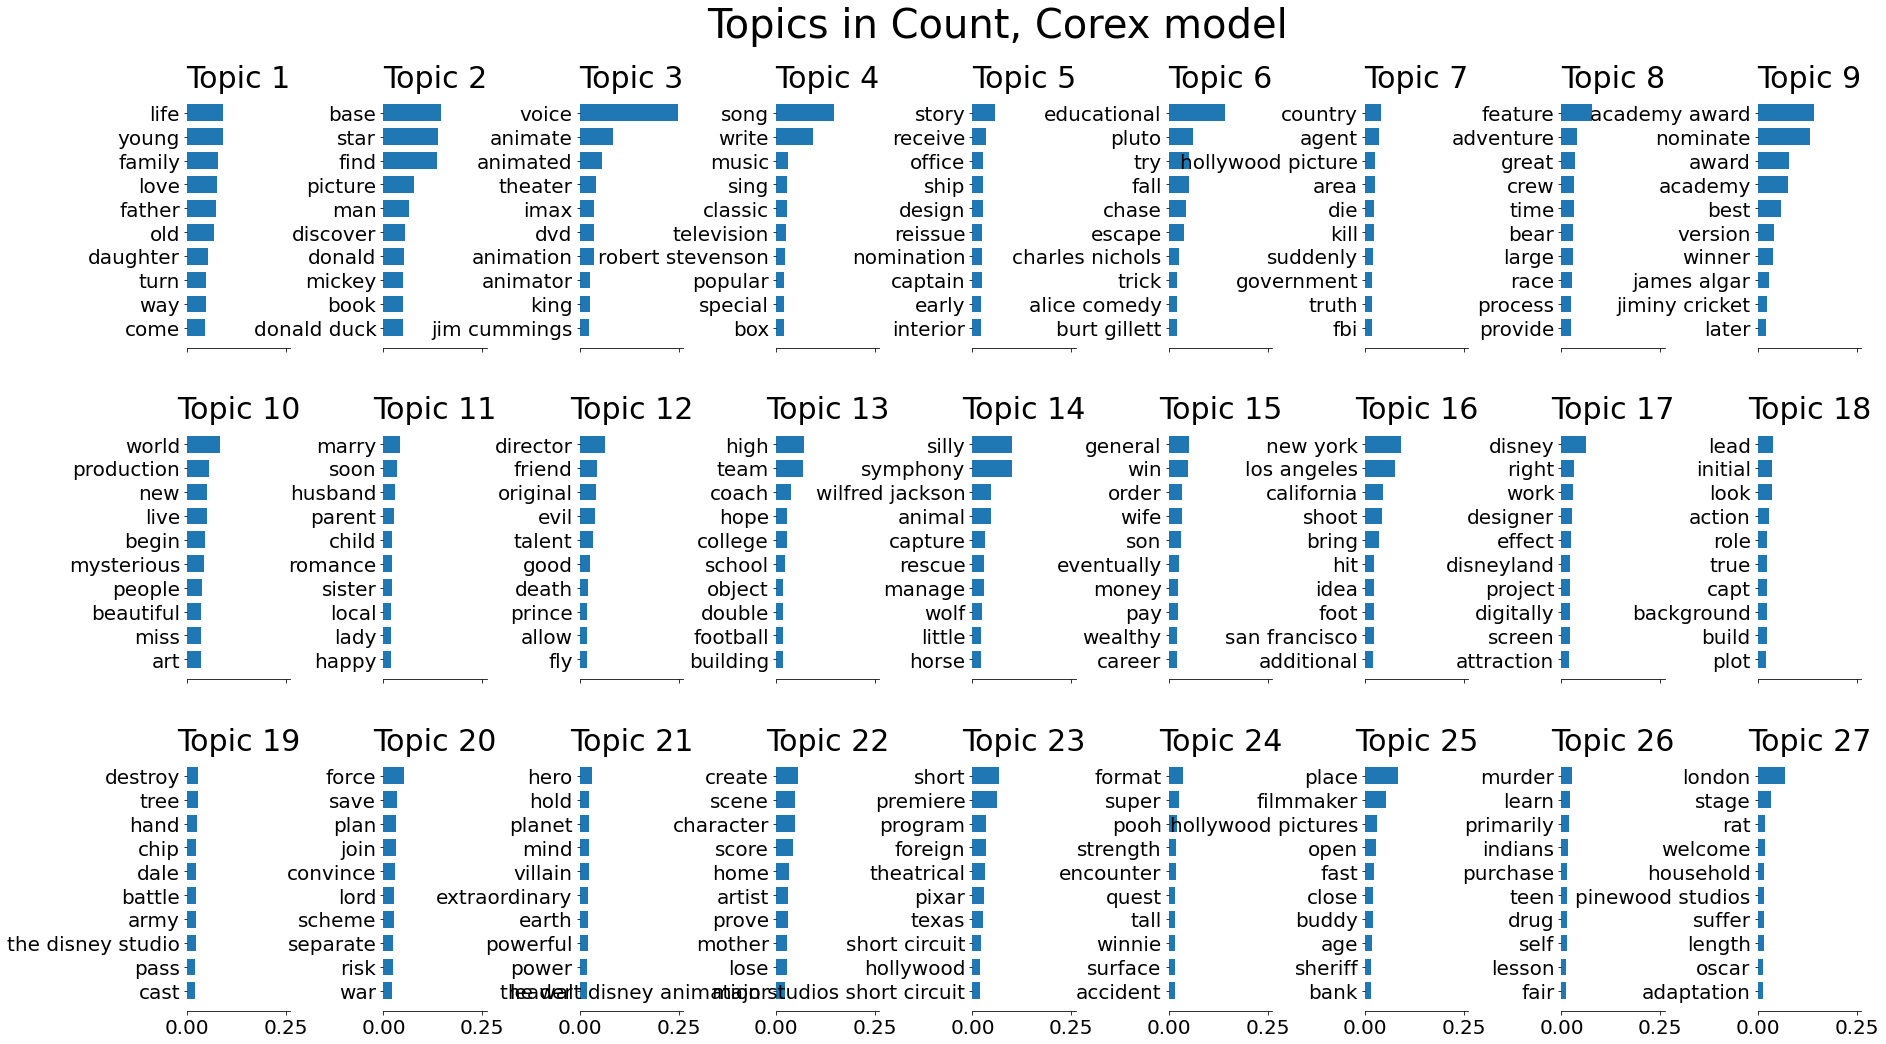

In [10]:
%matplotlib inline

plot_top_words(topic_modeler, vectorizer.get_feature_names(), 10, 'Topics in Count, Corex model', rows=3, cols=9)

In [11]:
doc_topic_df = pd.DataFrame(topic_modeler.labels,
                            index = df['title'], 
                            columns=[f'topic_{n}' for n in range(1,27+1)])
doc_topic_df


,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,...,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27
title,,,,,,,,,,,,,,,,,,,,,
10 Things I Hate About You,True,True,False,False,False,True,True,False,False,False,...,True,False,True,False,True,False,False,True,False,False
101 Dalmatians,False,True,False,False,False,True,False,True,False,True,...,True,False,False,False,True,False,False,True,False,True
101 Dalmatians II: Patch's London Adventure,True,True,True,False,False,True,False,True,False,True,...,False,False,False,True,False,False,False,False,False,False
"101 Problems of Hercules, The",False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
102 Dalmatians,False,False,False,False,False,True,False,False,True,False,...,True,False,True,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zenith,False,True,True,False,False,True,True,False,False,False,...,False,False,True,False,False,True,False,False,False,False
Zokkomon,False,True,False,False,False,False,False,False,False,True,...,False,False,False,True,False,False,True,False,False,False
Zootopia,True,False,True,False,False,False,False,True,False,False,...,True,False,False,False,True,False,True,True,True,False


In [12]:
doc_topic_df = pd.DataFrame(topic_modeler.p_y_given_x,
                            #index = df['title'], 
                            columns=[f'topic_{n}' for n in range(1,27+1)])
doc_topic_df


,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,...,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27
0,0.507247,0.999040,0.001039,0.005476,0.003009,0.663804,0.999999,0.011156,0.004077,0.022010,...,0.999999,0.025661,0.999999,0.019374,0.788566,0.008832,0.035814,0.954104,0.037676,0.026552
1,0.029290,0.999465,0.426531,0.000519,0.028151,0.900551,0.015546,0.999999,0.176812,0.652751,...,0.678987,0.320669,0.158974,0.019426,0.831752,0.008845,0.035794,0.994084,0.034100,0.999999
2,0.999999,0.862236,0.999999,0.103920,0.003027,0.900695,0.015628,0.999994,0.004081,0.575019,...,0.026353,0.092968,0.022640,0.999999,0.374986,0.009411,0.036398,0.058724,0.035311,0.201406
3,0.001456,0.366833,0.001039,0.003653,0.003009,0.000157,0.015544,0.048788,0.004077,0.152443,...,0.108301,0.025635,0.022580,0.019386,0.024877,0.008826,0.038616,0.061189,0.999999,0.024106
4,0.001456,0.047295,0.008183,0.000512,0.003009,0.999999,0.180764,0.048707,0.999999,0.022002,...,0.999999,0.025613,0.999999,0.999977,0.024898,0.008819,0.035822,0.057128,0.035064,0.030244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2105,0.001456,0.856440,0.999999,0.000512,0.044182,0.900695,0.771020,0.011219,0.004077,0.022008,...,0.026357,0.092970,0.883090,0.152513,0.258590,0.999999,0.036017,0.057287,0.033472,0.026078
2106,0.001456,0.999999,0.001039,0.000513,0.003009,0.000123,0.015554,0.011170,0.010888,0.999909,...,0.026349,0.025642,0.022612,0.999999,0.024912,0.121372,0.999999,0.057698,0.034540,0.026561
2107,0.937077,0.328211,0.999999,0.000529,0.003009,0.140685,0.102802,0.999999,0.362726,0.220372,...,0.999832,0.025651,0.254402,0.019466,0.997111,0.008834,0.569734,0.999999,0.903479,0.026970
2108,0.001456,0.235827,0.005676,0.947218,0.999999,0.946409,0.015544,0.011182,0.004077,0.022007,...,0.026354,0.933258,0.022595,0.019390,0.024885,0.999748,0.035845,0.056751,0.033551,0.025110


## Test recommendation metrics

In [ ]:
def test_distance_metrics(movie_idx, n_recs=3):
    print(df['title'][movie_idx])
    print(df['original_summary'][movie_idx][:100] + '...')
    print('\n')
    
    distance_metrics = ['cosine', 'euclidean', 'l1', 'l2']
    
    for metric in distance_metrics:
        recs = pairwise_distances(np.array(doc_topic_df.iloc[movie_idx]).reshape(1,-1), doc_topic_df, metric=metric).argsort()[0][1:]
        print(f'Recommendations using {metric} distance metric:')
        
        for i in range(n_recs):
            print('\t', df['title'][recs[i]])
            #print('\t', df['original_summary'][recs[i]][:100] + '...')
        print('\n')
        

In [ ]:
test_distance_metrics(211)

In [ ]:
test_distance_metrics(1095)

In [ ]:
test_distance_metrics(1762)

In [ ]:
test_distance_metrics(2095)

In [ ]:
test_distance_metrics(260)

## Test single recommendations

In [13]:
def recommendation_single(movie_idx, n_recs=5):
    print(df['title'][movie_idx])
    print(df['original_summary'][movie_idx][:100] + '...')
    print('\n')
        
    recs = pairwise_distances(np.array(doc_topic_df.iloc[movie_idx]).reshape(1,-1), doc_topic_df, metric='cosine').argsort()[0][1:]
        
    for i in range(n_recs):
        print('\t', df['title'][recs[i]])
        print('\t', df['original_summary'][recs[i]][:100] + '...')
        print('\n')
    

In [14]:
doc_topic_df.iloc[210]

topic_1     0.999999
topic_2     0.999999
topic_3     0.999999
topic_4     0.999999
topic_5     0.999999
topic_6     0.000001
topic_7     0.998156
topic_8     0.999999
topic_9     0.999999
topic_10    0.999999
topic_11    0.999999
topic_12    0.999999
topic_13    0.999999
topic_14    0.999999
topic_15    0.999994
topic_16    0.999999
topic_17    0.999999
topic_18    0.999999
topic_19    0.025654
topic_20    0.023318
topic_21    0.145268
topic_22    0.999999
topic_23    0.704404
topic_24    0.036344
topic_25    0.918309
topic_26    0.153213
topic_27    0.999999
Name: 210, dtype: float64

In [ ]:
recommendation_single(210, n_recs=3)

In [15]:
doc_topic_df.iloc[1762]

topic_1     0.365813
topic_2     0.999999
topic_3     0.999999
topic_4     0.005799
topic_5     0.999999
topic_6     0.999999
topic_7     0.999997
topic_8     0.999999
topic_9     0.988986
topic_10    0.999999
topic_11    0.011546
topic_12    0.999999
topic_13    0.212646
topic_14    0.008710
topic_15    0.999999
topic_16    0.993922
topic_17    0.015174
topic_18    0.927318
topic_19    0.247692
topic_20    0.206728
topic_21    0.999948
topic_22    0.422511
topic_23    0.927690
topic_24    0.999755
topic_25    0.059382
topic_26    0.036008
topic_27    0.029477
Name: 1762, dtype: float64

In [ ]:
recommendation_single(1762, n_recs=3)

## Test pair recommendations

In [ ]:
def recommendation_pair(movie_idx_1, movie_idx_2, n_recs=5):
    print('First selected movie:')
    print(df['title'][movie_idx_1])
    print(df['original_summary'][movie_idx_1][:100] + '...')
    print('\n')
    
    print('Second selected movie:')
    print(df['title'][movie_idx_2])
    print(df['original_summary'][movie_idx_2][:100] + '...')
    print('\n')
    
    print('Getting recommendations...')
    
    recs_1 = pairwise_distances(np.array(doc_topic_df.iloc[movie_idx_1]).reshape(1,-1), doc_topic_df, metric='cosine').argsort()[0]
    recs_2 = pairwise_distances(np.array(doc_topic_df.iloc[movie_idx_2]).reshape(1,-1), doc_topic_df, metric='cosine').argsort()[0]

    rec_ranks = []
    for i,title in enumerate(df['title']):
        rec_ranks.append(list(recs_1).index(i) + list(recs_2).index(i)) 
        
    rec_idx = np.argpartition(rec_ranks, n_recs)
    
    print('\n')
    if (movie_idx_1 in rec_idx[:n_recs]):
        n_recs += 1
    if (movie_idx_2 in rec_idx[:n_recs]):
        n_recs += 1
    if (movie_idx_1 == movie_idx_2):
        n_recs -= 1
        
    for i in rec_idx[:n_recs]:
        if i not in [movie_idx_1, movie_idx_2]:
            print('\t', df['title'][i])
            print('\t', df['original_summary'][i][:100] + '...')
            print('\n')
    
    return

In [ ]:
recommendation_pair(210, 1762, n_recs=3)

In [ ]:
recommendation_pair(210, 1522, n_recs=3)

In [ ]:
# Walt Disney's favorite movies: Bambi, Dumbo
recommendation_pair(184, 584, 3)

In [ ]:
recommendation_pair(1896, 1981, n_recs=3)

In [ ]:
doc_topic_df.to_pickle('doc_topic_df.pkl')
df.to_pickle('movie_summaries.pkl')
